# Anime Image Labeller

Using the https://www.kaggle.com/alamson/safebooru dataset.

## 0. Setup

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 7.3 MB/s 
     |████████████████████████████████| 48 kB 6.1 MB/s 
     |████████████████████████████████| 189 kB 72.6 MB/s 
     |████████████████████████████████| 1.2 MB 67.9 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 51 kB 312 kB/s 
     |████████████████████████████████| 558 kB 59.2 MB/s 
     |████████████████████████████████| 130 kB 58.5 MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *

In [ ]:
load_learner?

In [ ]:
import os.path

In [ ]:
from fastai.callback.fp16 import *

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = Path('gdrive/MyDrive/anime-image-labeller/safebooru')

## 1. Data Collection

In [ ]:
!pip install -Uqq opendatasets

In [ ]:
import opendatasets as od

In [ ]:
path = Path('gdrive/MyDrive/anime-image-labeller')

"username":"curttigges","key":"2cd7a4db172413af72b9ca64e5d8eb56"

In [ ]:
od.download("https://www.kaggle.com/alamson/safebooru",data_dir=path)

In [ ]:
path = Path('gdrive/MyDrive/anime-image-labeller/safebooru')

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

In [ ]:
df = pd.read_csv(str(path/'all_data.csv'))

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df['sample_url'] = (df['sample_url'].str.strip('/'))

In [ ]:
df.head()

In [ ]:
dest = 'images/im23868.jpg'

In [ ]:
img = download_url(df.iloc[23868,4] if df.iloc[23868,4] == 'h' else 'http://' +df.iloc[23868,4], dest)

In [ ]:
im = Image.open('images/im23868.jpg')

In [ ]:
im

In [ ]:
df.iloc[23868,8]

In [ ]:
df_s = df.sample(100000)

In [ ]:
df_s.head()

In [ ]:
urls = [i if i[0] == 'h' else 'http://' + i for i in df_s.iloc[:,4]]

In [ ]:
download_images(path/'images',urls=urls, max_pics=100000, preserve_filename=True)

In [ ]:
#!rm -rf 'safebooru/images'

In [ ]:
df_s['img_name'] = [re.findall(r'[^/]*$', df_s.iloc[i,4])[0] for i in range(len(urls))] #[^,]*$

In [ ]:
df_s.head()

In [ ]:
df_s['file_found'] = [os.path.isfile(path/'images'/df_s.iloc[i,9]) for i in range(len(df_s))]

In [ ]:
df_s = df_s[df_s['file_found']]

In [ ]:
df_s.to_pickle(path/'df_s.pkl')

## 2. Data Prep

In [ ]:
df_50k = pd.read_pickle(path/'df_s.pkl')

In [ ]:
df_s = df_50k.sample(n=1000)

In [ ]:
len(df_s)

1000

In [ ]:
tag_dict = {}
for i in df_s.tags:
    tokens = re.split("[ ]",i)
    for token in tokens:
        if token in tag_dict:
          tag_dict[token] += 1
        else:
          tag_dict[token] = 1

item = sorted(tag_dict.items(), key = lambda x:x[1],reverse = True)
print("10 top tags:")
for i in range(0,20):
    print(item[i])

10 top tags:
('solo', 466)
('long_hair', 465)
('1girl', 436)
('highres', 352)
('smile', 292)
('blush', 257)
('short_hair', 240)
('looking_at_viewer', 235)
('blue_eyes', 222)
('open_mouth', 205)
('breasts', 193)
('skirt', 181)
('blonde_hair', 176)
('brown_hair', 167)
('multiple_girls', 166)
('hat', 165)
('red_eyes', 161)
('touhou', 160)
('gloves', 146)
('black_hair', 141)


In [ ]:
len(tag_dict)

5543

In [ ]:
pop_tags = {t for t in tag_dict if tag_dict[t] > 50}
len(pop_tags)

79

In [ ]:
#df_s['img_name'] = [str(i).zfill(8)+'.'+re.findall(r'[^.]*$', df_s.iloc[i,4])[0] for i in range(len(urls))] #[^,]*$

In [ ]:
def get_x(r): return path/'images'/r['img_name']
def get_y(r): return [t for t in r['tags'].split(' ') if t in pop_tags]

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.3),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = db.dataloaders(df_s)

In [ ]:
dls.show_batch(nrows=1, ncols=5)

In [ ]:
db.dataloaders?

## 3. Training Smaller Models

### Result Assessment Functions

In [ ]:
"""
Get the prediction labels and their accuracies, then return the results as a dictionary.

[obj] - tensor matrix containing the predicted accuracy given from the model
[learn] - fastai learner needed to get the labels
[thresh] - minimum accuracy threshold to returning results
"""
def get_pred_classes(obj, learn, thresh):
    labels = []
    # get list of classes from Learner object
    for item in dls.vocab:
        labels.append(item)

    predictions = {}
    x=0
    for item in obj:
        acc= round(item.item(), 3)*100
#         acc= int(item.item()*100) # no decimal places
        if acc > thresh:
            predictions[labels[x]] = acc
        x+=1
        
    # sorting predictions by highest accuracy
    predictions ={k: round(v, 2) for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse=True)}

    return predictions

In [ ]:
def predict_single_img(imf, learn, imtype, thresh=20):
  if imtype == 'l':
    img = PILImage.create(imf)
  elif imtype == 'w':
    dl = download_url(imf, dest=path/'test')
    img = PILImage.create(dl)
  else:
    print("Invalid image type.")

  img.show() #show image
  _, _, pred_pct = learn.predict(img) #predict while ignoring first 2 array inputs
  print(get_pred_classes(pred_pct, learn, thresh))

In [ ]:
def shows_accs(learn, thresmin=0.05, thresmax=0.95, threscnt=29):
  preds, targs = learn.get_preds()
  xs = torch.linspace(thresmin,thresmax,threscnt)
  accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
  plt.plot(xs,accs);

### A. Baseline Model

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
lr_min, lr_steep

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()
learn.fine_tune(8, 1e-2, freeze_epochs=2)

In [ ]:
dls.train.bs

In [ ]:
learn.recorder.plot_loss()

In [ ]:
predict_single_img(path/'test/choker.jpeg', learn, 'l')

In [ ]:
shows_accs(learn, thresmin=0.05, thresmax=0.95, threscnt=29)

### B. Progressive Resizing

In [ ]:
def get_dls(bs, size):
    db = DataBlock(
      blocks=(ImageBlock, MultiCategoryBlock),
      get_x=get_x,
      get_y=get_y,
      splitter=RandomSplitter(valid_pct=0.3),
      item_tfms=Resize(460),
      batch_tfms=aug_transforms(size=size, min_scale=0.75)
    )
    return db.dataloaders(df_50k, bs=bs)

In [ ]:
dls = get_dls(128, 128)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()
learn.fit_one_cycle(5, 1e-2)

In [ ]:
learn.dls = get_dls(64, 224)
learn.fine_tune(8, 1e-2)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
predict_single_img(path/'test/choker.jpeg', learn, 'l')

In [ ]:
shows_accs(learn, thresmin=0.05, thresmax=0.95, threscnt=29)

### C. Test-Time Augmentation

In [ ]:
preds,targs = learn.tta()
accuracy_multi(preds, targs).item()

### D. MixUp

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2),
                    cbs=MixUp()).to_fp16()
learn.fine_tune(40, 1e-2, freeze_epochs=2)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
predict_single_img(path/'test/choker.jpeg', learn, 'l')

In [ ]:
shows_accs(learn, thresmin=0.05, thresmax=0.95, threscnt=29)

### E. Label Smoothing

### F. Combination of Successful Approaches

In [ ]:
dls = get_dls(128, 128)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2),
                    cbs=MixUp()).to_fp16()
learn.fit_one_cycle(20, 1e-2)

In [ ]:
learn.dls = get_dls(64, 224)
learn.fine_tune(20, 1e-2)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.dls = get_dls(32, 312)
learn.fine_tune(20, 1e-2)

In [ ]:
predict_single_img(path/'test/choker.jpeg', learn, 'l')

In [ ]:
shows_accs(learn, thresmin=0.05, thresmax=0.95, threscnt=29)

### Mixup Wins!

## 4. Training Medium-Sized Model

In [ ]:
df_m = df_50k.sample(n=7500)

In [ ]:
tag_dict = {}
for i in df_m.tags:
    tokens = re.split("[ ]",i)
    for token in tokens:
        if token in tag_dict:
          tag_dict[token] += 1
        else:
          tag_dict[token] = 1

item = sorted(tag_dict.items(), key = lambda x:x[1],reverse = True)
print("10 top tags:")
for i in range(0,20):
    print(item[i])

In [ ]:
len(tag_dict)

In [ ]:
pop_tags = {t for t in tag_dict if tag_dict[t] > 25}
len(pop_tags)

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [ ]:
dls = db.dataloaders(df_m)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
lr_min, lr_steep

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2),
                    cbs=MixUp()).to_fp16()
learn.fine_tune(40, 1e-2, freeze_epochs=2)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
predict_single_img(path/'test/hatsune.jpeg', learn, 'l', thresh=15)

In [ ]:
shows_accs(learn, thresmin=0.05, thresmax=0.95, threscnt=29)

## 5. Training a Large Model

In [ ]:
tag_dict = {}
for i in df_50k.tags:
    tokens = re.split("[ ]",i)
    for token in tokens:
        if token in tag_dict:
          tag_dict[token] += 1
        else:
          tag_dict[token] = 1

item = sorted(tag_dict.items(), key = lambda x:x[1],reverse = True)
print("10 top tags:")
for i in range(0,20):
    print(item[i])

10 top tags:
('solo', 25617)
('1girl', 24414)
('long_hair', 23516)
('highres', 18210)
('smile', 15949)
('short_hair', 14646)
('blush', 13001)
('looking_at_viewer', 12920)
('open_mouth', 11153)
('breasts', 10749)
('blue_eyes', 10307)
('blonde_hair', 9913)
('skirt', 9595)
('touhou', 9588)
('brown_hair', 9492)
('multiple_girls', 9204)
('hat', 8992)
('black_hair', 8097)
('red_eyes', 7863)
('simple_background', 7428)


In [ ]:
len(tag_dict)

67093

In [ ]:
pop_tags = {t for t in tag_dict if tag_dict[t] > 100}
len(pop_tags)

1356

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [ ]:
dls = db.dataloaders(df_50k, batch_size=128)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.02),
                    cbs=MixUp())
learn.fine_tune(40, 1e-2)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expe

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expe

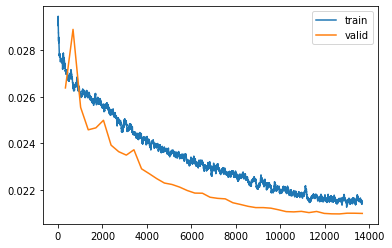

In [ ]:
learn.recorder.plot_loss()

{'solo': 59.6, 'short_hair': 56.9, '1girl': 50.1, 'highres': 24.4, 'blush': 23.1, 'smile': 22.1, 'looking_at_viewer': 18.2, 'black_hair': 16.8, 'original': 15.2, 'green_hair': 14.5, 'green_eyes': 13.9, 'shirt': 12.4, 'school_uniform': 11.9, '1boy': 11.6, 'bangs': 11.4, 'upper_body': 10.9, 'brown_hair': 10.6, 'brown_eyes': 10.4, 'idolmaster': 9.0, 'open_mouth': 9.0, 'long_sleeves': 8.6, 'grey_hair': 8.3, 'jacket': 8.0, 'eyebrows_visible_through_hair': 7.6, 'long_hair': 7.5, 'commentary_request': 7.3, 'male_focus': 7.2, 'hair_ornament': 6.9, 'skirt': 6.6, 'silver_hair': 6.1, 'red_eyes': 6.0, 'dress': 5.8, 'indoors': 5.8, 'closed_mouth': 5.6, 'tagme': 5.6, 'closed_eyes': 5.2, 'bag': 5.1}


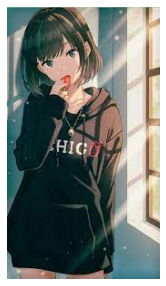

In [ ]:
predict_single_img(path/'test/girl.jpeg', learn, 'l', thresh=5)

In [ ]:
shows_accs(learn, thresmin=0.05, thresmax=0.95, threscnt=29)

In [ ]:
learn.export(path/'model-large-40e.pkl')

### Continue Training

In [ ]:
learn = load_learner(path/'model-large-40e.pkl',cpu=False)

In [ ]:
learn.dls = get_dls(128, 224)

(5.754399353463669e-07, 6.309573450380412e-07)

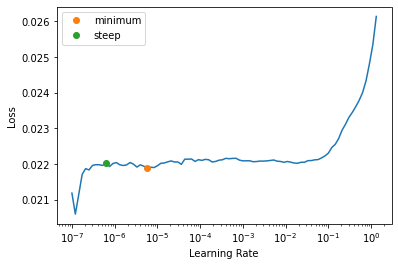

In [ ]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
lr_min, lr_steep

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(1e-2,))

KeyboardInterrupt: ignored

In [ ]:
with open('classes.txt', 'w+') as f:
  for item in dls.vocab:
    f.write(item+'\n')